# Imports

In [1]:
import numpy as np
%cd ..
# I need this to access modules from the main folder. Do not move this comment up into the same line

import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
sns.set_theme(style="white")


from generate_dataframe import generate_sentences_and_meta_df_from_multiple_files
from load_saved_dataframe import load_saved_df
from numerals import group_nums, parse_num_groups, num_list, find_roundedness, find_uncertainty, is_about_money, has_approximator, is_time_of_day
from helper_methods import try_apply, drop_na_with_count

C:\Users\karla\PycharmProjects\gender_linguistics_on_ParlaMint


# Set Parameters

In [2]:
# loading
load_path = None # "C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}.csv"

# generating
number_of_files = None # set to None to use all 1795 files, set to n<1795 to use n randomly chosen files
random_seed = 1341995

# dropping undesired data
int_lower_threshold = 2500 # set to None to keep all ints, set to n to drop all ints with absolute value < n
drop_time_of_day: bool = True

# saving?
saving: bool = True
save_name = "2023-03-15_complete"

figures_save_path = "C:/Users/karla/My Drive/Uni/LMU/Englisch/Zula/figures"
validity_save_path = "C:/Users/karla/My Drive/Uni/LMU/Englisch/Zula/validity"
qualitative_analysis_save_path = "C:/Users/karla/My Drive/Uni/LMU/Englisch/Zula/qualitative_analysis"

# Load / Generate

In [3]:
if load_path:
    df = load_saved_df(load_path)
else:
    df = generate_sentences_and_meta_df_from_multiple_files(number_of_files=number_of_files, random_seed=random_seed)
    if saving:
        df.to_csv(f"C:/Users/karla/Desktop/Zula_Data_all_in_one/{save_name}.csv")
complete_df = df

Generating Dataframe: 100%|██████████| 1795/1795 [3:16:08<00:00,  6.56s/it]  


In [4]:
n_sentences = df.shape[0]
print(f"total # of sentences: {n_sentences}")

drops_per_func_in_sentences = {}

df, drops_per_func_in_sentences['missing values in dataset'] = drop_na_with_count(df)
print(f"#sentences_dropped_due_to_original_nan: {drops_per_func_in_sentences['missing values in dataset']}")

total # of sentences: 852883
#sentences_dropped_due_to_original_nan: 3965


# Numerals

In [5]:
func_arg_res = [(group_nums, 'sentence', 'sentence_grouped_nums'),
             (parse_num_groups, 'sentence_grouped_nums', 'sentence_parsed_num_groups'),
             (num_list, 'sentence_parsed_num_groups', 'NUMs')]
            # function, argument_column, result_column

for func, arg_col, res_col in func_arg_res:
    func_name = func.__name__
    print(f"Applying {func_name}")
    df[res_col] = df[arg_col].swifter.apply((lambda c: try_apply(func, c)))
    df, drops_per_func_in_sentences[f"{func_name} failed"] = drop_na_with_count(df)

print("drop_reason".rjust(25)+" | #sentences_dropped"+"\n"+("="*46))
for func_name, drops in drops_per_func_in_sentences.items():
    print(func_name.rjust(25)+f" | {drops}")

Applying group_nums


Pandas Apply:   0%|          | 0/848918 [00:00<?, ?it/s]

Applying parse_num_groups


Pandas Apply:   0%|          | 0/838503 [00:00<?, ?it/s]

Applying num_list


Pandas Apply:   0%|          | 0/829310 [00:00<?, ?it/s]

              drop_reason | #sentences_dropped
missing values in dataset | 3965
        group_nums failed | 10415
  parse_num_groups failed | 9193
          num_list failed | 0


In [6]:
df = df.explode('NUMs').reset_index(drop=True)
df['num_index'], placeholder = zip(*df['NUMs'])
(df['num_as_str'], df['num_value']) = zip(*placeholder)

n_numbers = df.shape[0]
print(f"#numbers: {n_numbers}")

drops_per_func_in_numbers = {}

#numbers: 1241734


In [7]:
df['is_float-like'], df['n_proper_digits'], df['n_zeroes'], df['n_decimals'] = zip(*df['num_as_str'].swifter.apply(lambda cell: try_apply(find_roundedness, cell)))

df, drops_per_func_in_numbers['find_roundedness failed'] = drop_na_with_count(df)

print(f"#numbers_dropped_by_find_roundedness: {drops_per_func_in_numbers['find_roundedness failed']}")

Pandas Apply:   0%|          | 0/1241734 [00:00<?, ?it/s]

#numbers_dropped_by_find_roundedness: 7107


In [8]:
# we only want to keep those ints that have absolute values of 2500 or more and all float-likes
# therefore, get rid of all integers with absolute value of less than 2500
# keep track of number of dropped numbers
# save sample of dropped and not-dropped numbers to check validity of pipeline
if int_lower_threshold is not None:
    before_size = df.shape[0]

    drop_mask = ((df['is_float-like'] == False) & (abs(df['num_value']) < int_lower_threshold))

    # save sample of numbers that will be dropped
    df[drop_mask].sample(20, random_state=random_seed, axis=0).to_csv(f"{validity_save_path}/ints_below_threshold.csv")

    df = df.drop(df[drop_mask].index).reset_index(drop=True)

    # save sample of numbers that have not been dropped
    df.sample(20, random_state=random_seed, axis=0).to_csv(f"{validity_save_path}/ints_above_threshold_and_float-likes.csv")

    after_size = df.shape[0]
    print(f"dropped {before_size-after_size} integers with absolute value of less than 2500")

dropped 1056867 integers with absolute value of less than 2500


In [9]:
df['absolute_uncertainty'], df['relative_uncertainty'] =zip(*df.swifter.apply(lambda row: find_uncertainty(row), axis=1))

Pandas Apply:   0%|          | 0/177760 [00:00<?, ?it/s]

In [10]:
df['is_time_of_day'] = df.apply(lambda row: is_time_of_day(row), axis=1)

In [11]:
# now drop all numbers indicating the time of day, e.g. "10.30 pm"
# keep track of number of dropped numbers
# save sample of dropped and not-dropped numbers to check validity of pipeline
if drop_time_of_day:
    before_size = df.shape[0]

    drop_mask = df['is_time_of_day']

    # save sample of numbers that have not been dropped
    df[drop_mask].sample(20, random_state=random_seed, axis=0).to_csv(f"{validity_save_path}/times_of_day.csv")

    df = df.drop(df[drop_mask].index).reset_index(drop=True)

    # save sample of numbers that have not been dropped
    df.sample(20, random_state=random_seed, axis=0).to_csv(f"{validity_save_path}/not_times_of_day.csv")

    after_size = df.shape[0]
    print(f"dropped {before_size-after_size} numbers indicating the time of day, e.g. '10.30 pm'")

dropped 1361 numbers indicating the time of day, e.g. '10.30 pm'


In [12]:
df['is_about_money'] = df.apply(lambda row: is_about_money(row), axis=1)

# save samples
df[df['is_about_money']].sample(20, random_state=random_seed, axis=0).to_csv(f"{validity_save_path}/is_about_money")
df[df['is_about_money'] == False].sample(20, random_state=random_seed, axis=0).to_csv(f"{validity_save_path}/is_not_about_money")


df['has_approximator'], df['approximators'] = zip(*df.apply(lambda row: has_approximator(row), axis=1))

# save samples
df[df['has_approximator']].sample(20, random_state=random_seed, axis=0).to_csv(f"{validity_save_path}/with_approximator")
df[df['has_approximator'] == False].sample(20, random_state=random_seed, axis=0).to_csv(f"{validity_save_path}/without_approximator")

# Drops in Loading and Parsing Pipeline

## Dropped Sentences

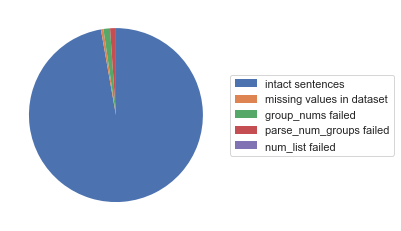

In [13]:
drop_sentences = list(drops_per_func_in_sentences.values())
drop_sentences.insert(0, n_sentences - sum(drop_sentences))
drop_sentences_labels = list(drops_per_func_in_sentences.keys())
drop_sentences_labels.insert(0, 'intact sentences')

plt.pie(drop_sentences, startangle=90, counterclock=False, wedgeprops = {'linewidth': 0})
plt.legend(drop_sentences_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f"{figures_save_path}/piecharts/dropped_sentences.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close()

## Dropped Numbers

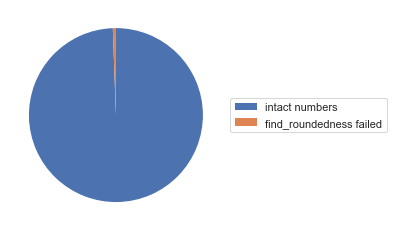

In [14]:
drop_numbers = list(drops_per_func_in_numbers.values())
drop_numbers.insert(0, n_numbers - sum(drop_numbers))
drop_numbers_labels = list(drops_per_func_in_numbers.keys())
drop_numbers_labels.insert(0, 'intact numbers')

plt.pie(drop_numbers, startangle=90, counterclock=False, wedgeprops = {'linewidth': 0})
plt.legend(drop_numbers_labels, loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig(f"{figures_save_path}/piecharts/dropped_numbers.png", dpi=600, bbox_inches='tight')
plt.show()
plt.close()

# Sampling Dataset to Check Validity of Preprocessing and Analysis Pipeline

In [15]:
sample_df = df.sample(n=100, random_state=random_seed, axis=0)
sample_df['num_as_str'] = sample_df['num_as_str'].apply(lambda s: "'"+s)
for full_sentence in ['sentence', 'sentence_grouped_nums', 'sentence_parsed_num_groups']:
    sample_df[full_sentence] = sample_df[full_sentence].apply(lambda s: s['form'])
sample_df.to_csv(f"{qualitative_analysis_save_path}/sample_for_limitations_section.csv")

# Plots

In [16]:
dfs = {'decimal numbers': df[df['is_float-like'] == True],
       'integers': df[df['is_float-like'] == False]
       }

binary_independent_variables = {'is_upper_house': ('house', 'lower house', 'upper house'),
                    'is_chairperson': ('speaker role', 'regular', 'chairperson'),
                    'is_mp': ('speaker type', 'not MP', 'MP'),
                    'is_female': ('gender', 'male', 'female'),
                    'is_coalition': ('party status', 'opposition', 'coalition'),
                    'is_about_money': ('counted entity', 'not money', 'money'),
                    'has_approximator': ('has an approximator', 'with', 'without')
                    }
                    # column_name, variable_name, value0 (False), value1 (True)

dependent_variables = {'num_value': 'number value',
                       # 'n_proper_digits': 'number of proper digits',
                       # 'n_zeroes': 'number of zeros',
                       # 'absolute_uncertainty': 'absolute uncertainty',
                       'relative_uncertainty': 'relative uncertainty'
                       }

max_dv_name_len = max((len(_dv) for _dv in dependent_variables))

## Scatterplots

In [17]:
plt.style.use('seaborn-deep')

for df_name, _df in dfs.items():

    for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():

        data = _df.copy()
        data[biv_name] = _df[biv_key].replace({False: biv_false_value, True: biv_true_value, 'n/a': 'other'}, inplace=False)

        x_axis = 'num_value'
        y_axis = 'relative_uncertainty'

        sns.scatterplot(x=x_axis, y=y_axis, hue=biv_name, data=data, style=biv_name) #alpha=0.2,

        plt.title(f"distribution of {df_name} by {biv_name}")
        plt.xlabel('number value')
        plt.ylabel('relative uncertainty')
        plt.legend(loc='upper right')

        plt.xscale('log')
        plt.savefig(f"{figures_save_path}/scatterplots/{df_name}--{biv_name}--x-{x_axis}--y-{y_axis}.png",
                    dpi=300)
        plt.close()

## Histograms

In [18]:
# TODO: fix width of bars
#  https://stackoverflow.com/questions/38234545/multiple-histograms-with-logarithmic-x-scale
#  https://stackoverflow.com/questions/30551694/logarithmic-multi-sequenz-plot-with-equal-bar-widths
#  or do step diagram instead
#  also consider different y-axes to normalize https://stackoverflow.com/a/47750425/18420741
# TODO: make sure max_number_value is part of diagram!
# TODO: only unit fractions for relative_uncertainty

plt.style.use('seaborn-deep')

for df_name, _df in dfs.items():

    for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():

        for dv, dv_name in dependent_variables.items():

            distribution_biv_true = _df[_df[biv_key] == True][dv]
            distribution_biv_false = _df[_df[biv_key] == False][dv]
            distribution_biv_other = _df[(_df[biv_key] != True) & (_df[biv_key] != False)][dv]

            if distribution_biv_other.shape[0] == 0:
                distributions = [distribution_biv_true, distribution_biv_false]
                labels = [biv_true_value, biv_false_value]
            else:
                distributions = [distribution_biv_true, distribution_biv_false, distribution_biv_other]
                labels = [biv_true_value, biv_false_value, 'other']


            for normed in (True, False):
                if normed:
                    plt.title(f"{df_name} by {biv_name} - normalized")
                    save_path = f"{figures_save_path}/histograms/{df_name}-{dv}-{biv_name}-normalized.png"
                    plt.ylabel("percentage")
                else:
                    plt.title(f"{df_name} by {biv_name}")
                    save_path = f"{figures_save_path}/histograms/{df_name}-{dv}-{biv_name}-not_normalized.png"
                    plt.ylabel("count")

                plt.xlabel(dv_name)

                if dv in {'num_value', 'absolute_uncertainty'}:
                    plt.xscale('log')
                    bins = [5**i for i in range(30)]
                elif dv == 'relative_uncertainty':
                    bins = [0.05*i for i in range(21)]
                else:
                    bins = range(15)

                if normed:
                    plt.hist(distributions, bins=bins, weights=[np.ones(len(dist)) / len(dist) for dist in distributions]) # labels=labels,
                    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
                else:
                    plt.hist(distributions, bins=bins) #, label=labels) # , histtype='step')

                plt.legend(title=biv_name, labels=labels,  loc='upper right')

                plt.savefig(
                    save_path,
                    dpi=300,
                    bbox_inches="tight")
                plt.close()

## Boxplots

In [19]:
from plotting import compute_dataframe_grouping, BOX_PLOT_STEP, BOX_PLOT_WIDTH, CATEGORY_LABEL_POSITION, COLUMN_LABEL_MAPPING, FONT_SIZE_AXIS_LABEL, FONT_SIZE_TITLE, FONT_SIZE_X_TICK, GAP_BETWEEN_CATEGORIES, PLOT_DEFAULT_WIDTH

### Single Categories

C:\Users\karla\AppData\Local\Temp/ipykernel_13668/2275607951.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])
C:\Users\karla\AppData\Local\Temp/ipykernel_13668/2275607951.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])
C:\Users\karla\AppData\Local\Temp/ipykernel_13668/2275607951.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])
C:\Users\karla\AppData\Local\Temp/ipykernel_13668/2275607951.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])
C:\Users\karla\AppData\Local\Temp/ipykernel_13668/2275607951.py:43: UserWarning: FixedFormatter 

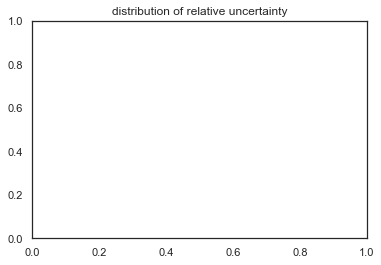

In [20]:
plt.style.use('seaborn-deep')

for df_name, _df in dfs.items():

    for dv, dv_name in dependent_variables.items():
        plt.title(f"distribution of {dv_name}")

        for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():

            combined_df = _df[dv].to_frame(name='total') #.rename(columns={dv: 'total'})

            combined_df[biv_true_value] = _df[_df[biv_key] == True][dv]
            combined_df[biv_false_value] = _df[_df[biv_key] == False][dv]

            distribution_biv_other = _df[(_df[biv_key] != True) & (_df[biv_key] != False)][dv]
            if distribution_biv_other.shape[0] != 0:
                combined_df['other'] = distribution_biv_other

            box_plot_x_positions, category_separator_x_positions = compute_dataframe_grouping(combined_df, binary_independent_variables)

            figwidth = PLOT_DEFAULT_WIDTH + len(combined_df.columns) * BOX_PLOT_WIDTH

            combined_df.plot(kind='box', rot=45, showfliers=False, positions=box_plot_x_positions, widths=0.5, figsize=(figwidth, 6), whis=(5,95))


            plt.title(f"{df_name} by {biv_name}")
            plt.ylabel(dv_name)

            # Set font sizes
            plt.gca().yaxis.label.set_fontsize(FONT_SIZE_AXIS_LABEL)
            plt.gca().title.set_fontsize(FONT_SIZE_TITLE)
            for x_tick_label in plt.gca().get_xticklabels():
                x_tick_label.set_fontsize(FONT_SIZE_X_TICK)

            # Plot separators between categories
            for category_separator_x_position in category_separator_x_positions:
                plt.axvline(category_separator_x_position, linestyle='--', color='darkgray')

            # change y_axis ticks, so they don't say 1e6 at the top of the y_axis and coefficients on the ticks
            # instead have it say 'million' if the value is in the millions
            current_y_ticks = plt.gca().get_yticks()
            if max(current_y_ticks) > 10 ** 6:
                plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])

            plt.savefig(f"{figures_save_path}/boxplots/{df_name}-{dv}-{biv_name}.png",
                        dpi=300,
                        bbox_inches="tight")

# for saving with log y-scale activate the following lines:
#            plt.yscale('log')

#            plt.savefig(f"{figures_save_path}/boxplots/{df_name}-{dv}-{biv_name}-log_scale.png",
#                        dpi=300,
#                        bbox_inches="tight")

#            plt.show()
            plt.close()

 ### All-in-One with normal money

In [21]:
plt.style.use('seaborn-deep')

# TODO: group by category @Tobias

for df_name, _df in dfs.items():

    for dv, dv_name in dependent_variables.items():
        combined_df = _df[dv].to_frame(name='total')

        # Select only columns listed in binary_independent_variables
        for biv_key, (biv_name, biv_false_value, biv_true_value) in binary_independent_variables.items():

            combined_df[biv_true_value] = _df[_df[biv_key] == True][dv]
            combined_df[biv_false_value] = _df[_df[biv_key] == False][dv]

            distribution_biv_other = _df[(_df[biv_key] != True) & (_df[biv_key] != False)][dv]
            if distribution_biv_other.shape[0] != 0:
                combined_df[f"{biv_name}: other"] = distribution_biv_other

        box_plot_x_positions, category_separator_x_positions = compute_dataframe_grouping(combined_df, binary_independent_variables)
        column_names = combined_df.columns
        column_names = [COLUMN_LABEL_MAPPING[col_name]
                        if col_name in COLUMN_LABEL_MAPPING
                        else col_name
                        for col_name in column_names]
        combined_df.columns = column_names

        combined_df.plot(kind='box', rot=45, figsize=(20, 4.8), showfliers=False, positions=box_plot_x_positions, whis=(5,95))

        # Plot separators between categories
        for category_separator_x_position in category_separator_x_positions:
            plt.axvline(category_separator_x_position, linestyle='--', color='darkgray')

        plt.title(f"{df_name}")
        plt.ylabel(dv_name)

        # Set font sizes
        plt.gca().yaxis.label.set_fontsize(FONT_SIZE_AXIS_LABEL)
        plt.gca().title.set_fontsize(FONT_SIZE_TITLE)
        for x_tick_label in plt.gca().get_xticklabels():
            x_tick_label.set_fontsize(FONT_SIZE_X_TICK)


        # change y_axis ticks, so they don't say 1e6 at the top of the y_axis and coefficients on the ticks
        # instead have it say 'million' if the value is in the millions
        current_y_ticks = plt.gca().get_yticks()
        if max(current_y_ticks) > 10 ** 6:
            plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])

        # Add category labels centered below the respective column names
        for i_category, (category, col_names) in enumerate(binary_independent_variables.items()):
            if i_category < len(binary_independent_variables.keys()) - 1:
                # Position of category label is computed by taking the middle positions of the
                # left and right category separator line
                category_label_x_position = (category_separator_x_positions[i_category] + category_separator_x_positions[i_category + 1]) / 2
            else:
                # Special case for the last category label since we don't have a separator line to the right of that
                category_label_x_position = category_separator_x_positions[i_category] + GAP_BETWEEN_CATEGORIES / 2 + (len(col_names) - 1) * BOX_PLOT_STEP / 2

            category_label_y_position = -CATEGORY_LABEL_POSITION* current_y_ticks[-1]
            category_label = col_names[0]
            plt.text(category_label_x_position, category_label_y_position, col_names[0], horizontalalignment='center', fontsize=15)


        plt.savefig(f"{figures_save_path}/boxplots/{df_name}-{dv}-all_in_one.png",
                    dpi=300,
                    bbox_inches="tight")

# for saving with log y-scale activate the following lines:
#        plt.yscale('log')

#        plt.savefig(f"{figures_save_path}/boxplots/{df_name}-{dv}-all_in_one-log_scale.png",
#                    dpi=300,
#                    bbox_inches="tight")


#        plt.show()
        plt.close()


C:\Users\karla\AppData\Local\Temp/ipykernel_13668/2447911931.py:48: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}M'.format(x/10**6)  for x in current_y_ticks])


# Qualitative Analysis: Generate .csv files

In [22]:
columns_to_investigate = ['sent_id', 'Speaker_name', 'is_coalition', 'is_mp', 'is_female', 'is_upper_house', 'is_chairperson', 'sentence_grouped_nums','num_value', 'is_float-like', 'relative_uncertainty', 'is_about_money', 'has_approximator', 'approximators']

# high number values
df[columns_to_investigate].sort_values(by='num_value', ascending=False, inplace=False).iloc[:100].to_csv(f"{qualitative_analysis_save_path}/high_number_values.csv")

# negative number values
df[columns_to_investigate][df['num_value'] < 0].to_csv(f"{qualitative_analysis_save_path}/negative_number_values.csv")

# low relative uncertainty
df[columns_to_investigate].sort_values(by='relative_uncertainty', ascending=True, inplace=False).iloc[:100].to_csv(f"{qualitative_analysis_save_path}/low_relative_uncertainty.csv")

# high relative uncertainty
df[columns_to_investigate].sort_values(by='relative_uncertainty', ascending=False, inplace=False).iloc[:100].to_csv(f"{qualitative_analysis_save_path}/low_relative_uncertainty.csv")

## Random Shit

In [23]:
df[df['is_float-like']][columns_to_investigate].sort_values(by='num_value', ascending=False, inplace=False).iloc[:100].to_csv(f"{qualitative_analysis_save_path}/float-likes--high_number_values.csv")

In [24]:
df[df['is_about_money']].shape

(89876, 26)